# Load packages

In [1]:
import numpy as np
import pandas as pd

#시각화
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so
import koreanize_matplotlib #한글 깨짐 방지
import plotly.express as px

#확률분포
from scipy.stats import uniform, randint

#모델 저장
import pickle

from statsmodels.stats.outliers_influence import variance_inflation_factor #다중공선성 VIF

#Scikit learn
from sklearn import tree
from sklearn.model_selection import train_test_split #데이터 분할
from sklearn.tree import plot_tree #결정트리 시각화
import graphviz #결정트리 시각화
from sklearn.tree import export_graphviz #결정트리 시각화
from sklearn.metrics import accuracy_score #정확도 구하기
from sklearn.pipeline import Pipeline #파이프라인
from sklearn.pipeline import make_pipeline # 특성공학 + 학습
from sklearn.impute import SimpleImputer # 결측값 단순 대치 기법
from sklearn.preprocessing import OneHotEncoder # 원핫인코딩(범주형변수 -> 수치형 변수)
from sklearn.linear_model import LogisticRegression # 로지스틱회귀
from sklearn.ensemble import RandomForestClassifier # 랜덤포레스트 분류
from sklearn.ensemble import RandomForestRegressor # 랜덤포레스트 회귀
from sklearn.ensemble import GradientBoostingClassifier # 그래디언트 부스트 분류
from sklearn.ensemble import GradientBoostingRegressor # 그래디언트 부스트 회귀
from sklearn.ensemble import AdaBoostClassifier #ada부스트 분류
from sklearn.tree import DecisionTreeClassifier #결정트리 분류
from sklearn.tree import DecisionTreeRegressor #결정트리 회귀
from sklearn.model_selection import GridSearchCV #그리드서치 하이퍼파라미터 튜닝
from sklearn.model_selection import RandomizedSearchCV #랜덤서치 하이퍼파라미터 튜닝
from sklearn.model_selection import cross_val_predict #Cross Validation predict
from sklearn.metrics import r2_score #결정계수
from sklearn.linear_model import LinearRegression #선형회귀
from sklearn.metrics import r2_score, mean_squared_error #결정계수, MSE
from sklearn.preprocessing import PolynomialFeatures #다항회귀
from sklearn.linear_model import Lasso #라쏘회귀
from sklearn.linear_model import Ridge #릿지회귀
from sklearn.linear_model import ElasticNet #엘라스틱넷 규제
from sklearn.preprocessing import StandardScaler #표준화
from sklearn.metrics import accuracy_score #정확도
from sklearn.metrics import f1_score #f1 score
from sklearn.metrics import roc_auc_score, roc_curve #ROC 곡선
from sklearn.metrics import confusion_matrix #오차행렬(실제, 예측 행렬)

# Load Titanic Data

In [2]:
data=pd.read_csv("Titanic-Dataset.csv")
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
data.shape

(891, 12)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


## 1) 결측치

In [5]:
data.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

- PassengerId	- 정수형	- 각 승객의 고유 식별 번호
- Survived	- 범주형	- 생존 여부 (0: 사망, 1: 생존)
- Pclass	- 범주형	- 좌석 등급 (1: 1등석, 2: 2등석, 3: 3등석)
- Name	- 문자열형	- 승객 이름
- Sex	- 범주형	- 승객 성별 (male, female)
- Age	- 실수형	- 승객 나이 (결측값 포함 가능)
- SibSp	- 정수형	- 함께 탑승한 형제/자매 또는 배우자 수
- Parch	- 정수형	- 함께 탑승한 부모/자녀 수
- Ticket	- 문자열형	- 티켓 번호
- Fare	- 실수형	- 티켓 요금
- Cabin	- 문자열형	- 선실 번호 (결측값이 많음)
- Embarked	- 범주형	- 탑승 항구 (C: Cherbourg, Q: Queenstown, S: Southampton)

1. cabin의 결측치가 데이터의 80%가량 차지한다. 하지만 이것은 생존률에 영향을 끼치지 않을 것이므로 제거하지 않는다.
2. age에 결측치가 데이터의 20%가량 차지하지만 이를 다른 값으로 보간할 수 없다. 따라서 제거해보자.

In [6]:
#Age결측값 제거
data.dropna(subset=["Age"], inplace=True)

In [7]:
data.shape

(714, 12)

## 2) 독립, 종속변수

우리는 생존률을 예측할것이다. 따라서 종속변수는 Survived이다.

In [8]:
X=data.drop("Survived", axis=1)
Y=data["Survived"]

In [9]:
X.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


우리는 단지 생존자 예측만 구할 것이다.<br>
따라서 PassengerId, Name, Ticket, Cabin, Embarked는 불필요한 변수들이다.

In [10]:
X.drop(["PassengerId", "Name", "Ticket", "Cabin", "Embarked"], axis=1, inplace=True)

## 3) 변수 변환

In [11]:
Y.head()

0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

종속변수는 변환할 것이 없다

In [12]:
X.head()

,Pclass,Sex,Age,SibSp,Parch,Fare
0,3,male,22.0,1,0,7.2500
1,1,female,38.0,1,0,71.2833
2,3,female,26.0,0,0,7.9250
3,1,female,35.0,1,0,53.1000
4,3,male,35.0,0,0,8.0500


1. SibSp와 Parch를 합쳐 동승객의 수 파생변수를 만들자

In [13]:
X["Family"]=X["SibSp"]+X["Parch"]
X.drop(["SibSp", "Parch"], axis=1, inplace=True)
X.head()

,Pclass,Sex,Age,Fare,Family
0,3,male,22.0,7.2500,1
1,1,female,38.0,71.2833,1
2,3,female,26.0,7.9250,0
3,1,female,35.0,53.1000,1
4,3,male,35.0,8.0500,0


2. Sex변수를 이진변수로 변환하자<br>
남자를 0, 여자를 1로 변환

In [14]:
X['Sex'] = X['Sex'].map({'male': 0, 'female': 1})
X.head()

,Pclass,Sex,Age,Fare,Family
0,3,0,22.0,7.2500,1
1,1,1,38.0,71.2833,1
2,3,1,26.0,7.9250,0
3,1,1,35.0,53.1000,1
4,3,0,35.0,8.0500,0


분류모델이니깐 표준화를 진행할 필요는 없다

### 다중공선성 확인

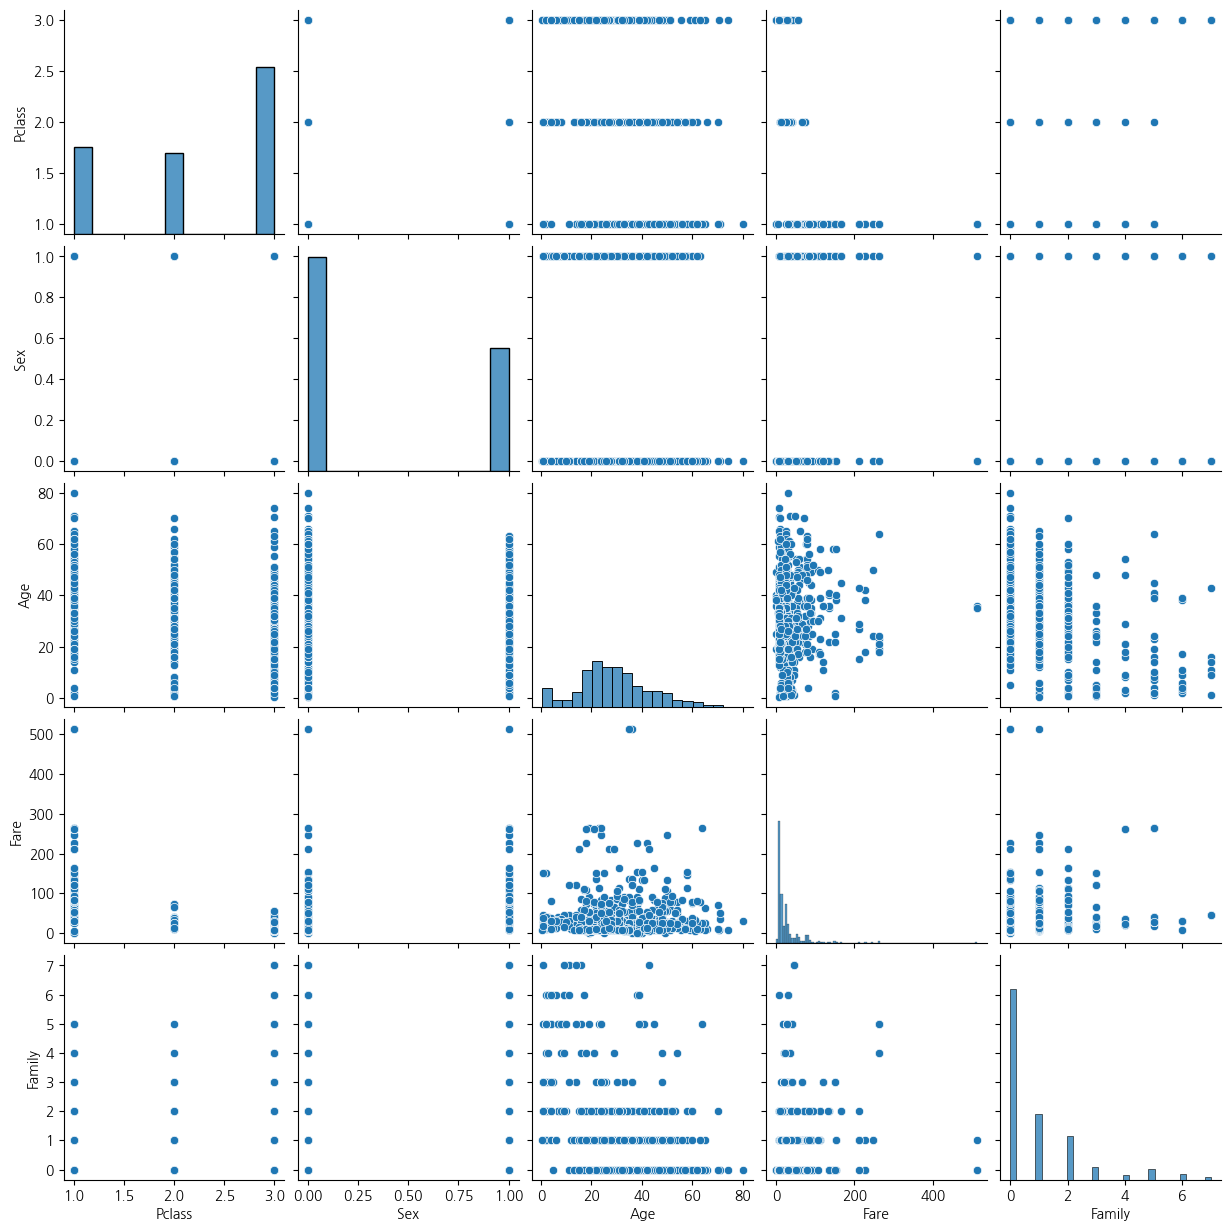

In [15]:
sns.pairplot(X)

In [16]:
X.corr()

,Pclass,Sex,Age,Fare,Family
Pclass,1.000000,-0.155460,-0.369226,-0.554182,0.056909
Sex,-0.155460,1.000000,-0.093254,0.184994,0.207165
Age,-0.369226,-0.093254,1.000000,0.096067,-0.301914
Fare,-0.554182,0.184994,0.096067,1.000000,0.204640
Family,0.056909,0.207165,-0.301914,0.204640,1.000000


Pclass랑 Fare의 상관관계가 높게 나온다<br>
VIF로 확인해보자

In [17]:
vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
vif_data

,Feature,VIF
0,Pclass,3.436466
1,Sex,1.619508
2,Age,3.445464
3,Fare,1.732824
4,Family,1.687446


Pclass와 Age의 VIF가 크지만 5를 넘지 않으므로 그대로 진행한다

## 4) 데이터 분할

In [18]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1234) #8:2로 분할

In [19]:
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((571, 5), (143, 5), (571,), (143,))

# Predict Survival

생존 여부는 이진변수로 저장되어있다. 따라서 분류모형을 설계한다

## 0. 분류모델 평가함수

In [20]:
def eval_classifier(model):
    Y_train_pred = model.predict(X_train)
    Y_test_pred = model.predict(X_test)
    Y_train_prob = model.predict_proba(X_train)[:, 1]
    Y_test_prob = model.predict_proba(X_test)[:, 1]
    print('학습 능력')
    print('학습 정확도 : ', accuracy_score(Y_train, Y_train_pred))
    print('학습 f1 score : ', f1_score(Y_train, Y_train_pred))
    print('학습 AUC : ', roc_auc_score(Y_train, Y_train_prob))
    print('\n')
    print('일반화 능력')
    print('검정 정확도 : ', accuracy_score(Y_test, Y_test_pred))
    print('검정 f1 score : ', f1_score(Y_test, Y_test_pred))
    print('검정 AUC : ', roc_auc_score(Y_test, Y_test_prob))

## 1. Decision Tree

In [21]:
model_decision_tree = DecisionTreeClassifier(random_state=1234)

In [22]:
hyperparam = {
    "criterion":["gini","entropy"], #지니계수, 엔트로피
    "max_depth": np.arange(1, 11, 1), #트리 최대 깊이 1~10
    "max_features": [None,"sqrt"] #최대 특성 개수
}

In [23]:
decision_grid = GridSearchCV(estimator=model_decision_tree, param_grid=hyperparam, cv=5, n_jobs=-1, verbose=1)

In [24]:
decision_grid.fit(X_train, Y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=1234),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
                         'max_features': [None, 'sqrt']},
             verbose=1)

In [25]:
decision_grid.best_params_

{'criterion': 'entropy', 'max_depth': 3, 'max_features': None}

In [26]:
best_decision_tree=decision_grid.best_estimator_

In [27]:
eval_classifier(best_decision_tree)

학습 능력
학습 정확도 :  0.8318739054290718
학습 f1 score :  0.7767441860465116
학습 AUC :  0.8705052893907028


일반화 능력
검정 정확도 :  0.7972027972027972
검정 f1 score :  0.7433628318584071
검정 AUC :  0.8723123732251522


## 2. Random Forest

In [28]:
model_random_forest = RandomForestClassifier(random_state=1234)

In [29]:
hyperparam = {
    "n_estimators": np.arange(40, 210, 10), #나무 개수
    "criterion":["gini","entropy"],
    "max_depth": np.arange(1, 11, 1),
    "max_features": [None,"sqrt"]
}

In [30]:
forest_grid = GridSearchCV(estimator=model_random_forest, param_grid=hyperparam, cv=5, n_jobs=-1, verbose=1)

In [31]:
forest_grid.fit(X_train, Y_train)

Fitting 5 folds for each of 680 candidates, totalling 3400 fits


c:\ProgramData\anaconda3\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=1234),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
                         'max_features': [None, 'sqrt'],
                         'n_estimators': array([ 40,  50,  60,  70,  80,  90, 100, 110, 120, 130, 140, 150, 160,
       170, 180, 190, 200])},
             verbose=1)

In [32]:
forest_grid.best_params_

{'criterion': 'entropy',
 'max_depth': 4,
 'max_features': None,
 'n_estimators': 60}

In [33]:
best_random_forest=forest_grid.best_estimator_

In [34]:
eval_classifier(best_random_forest)

학습 능력
학습 정확도 :  0.8458844133099825
학습 f1 score :  0.7894736842105263
학습 AUC :  0.9135451632590783


일반화 능력
검정 정확도 :  0.8041958041958042
검정 f1 score :  0.7454545454545455
검정 AUC :  0.86947261663286


## 3. Gradient Boost

In [35]:
model_gradient = GradientBoostingClassifier(random_state=1234)

In [36]:
hyperparam = {
    "loss": ["deviance", "exponential"], #손실함수
    "n_estimators": np.arange(40, 210, 10),
    "learning_rate": np.arange(0.01, 0.21, 0.01), #학습률
    "max_depth": np.arange(3, 8, 1),
    "max_features": ["sqrt"]
}

In [37]:
gradient_grid=GridSearchCV(estimator=model_gradient, param_grid=hyperparam, cv=5, n_jobs=-1, verbose=1)

In [38]:
gradient_grid.fit(X_train, Y_train)

Fitting 5 folds for each of 3400 candidates, totalling 17000 fits


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
8500 fits failed out of a total of 17000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5637 fits failed with the following error:
Traceback (most recent call last):
  File "c:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "c:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "c:\ProgramData\anaconda3\Lib\site-pa

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=1234),
             n_jobs=-1,
             param_grid={'learning_rate': array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 ]),
                         'loss': ['deviance', 'exponential'],
                         'max_depth': array([3, 4, 5, 6, 7]),
                         'max_features': ['sqrt'],
                         'n_estimators': array([ 40,  50,  60,  70,  80,  90, 100, 110, 120, 130, 140, 150, 160,
       170, 180, 190, 200])},
             verbose=1)

In [39]:
gradient_grid.best_params_

{'learning_rate': 0.01,
 'loss': 'exponential',
 'max_depth': 5,
 'max_features': 'sqrt',
 'n_estimators': 100}

In [40]:
best_gradient_boost=gradient_grid.best_estimator_

In [41]:
eval_classifier(best_gradient_boost)

학습 능력
학습 정확도 :  0.861646234676007
학습 f1 score :  0.8068459657701712
학습 AUC :  0.9434505645407385


일반화 능력
검정 정확도 :  0.8041958041958042
검정 f1 score :  0.7407407407407407
검정 AUC :  0.8852941176470588


## 4. Ada Boost

In [42]:
model_ada_boost = AdaBoostClassifier(random_state=1234)

In [43]:
hyperparam = {
    "n_estimators": np.arange(40, 210, 10),
    "learning_rate": np.arange(0.1, 3, 0.1)
}

In [44]:
ada_grid=GridSearchCV(estimator=model_ada_boost, param_grid=hyperparam, cv=5, n_jobs=-1, verbose=1)

In [45]:
ada_grid.fit(X_train, Y_train)

Fitting 5 folds for each of 493 candidates, totalling 2465 fits


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


GridSearchCV(cv=5, estimator=AdaBoostClassifier(random_state=1234), n_jobs=-1,
             param_grid={'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
       1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6,
       2.7, 2.8, 2.9]),
                         'n_estimators': array([ 40,  50,  60,  70,  80,  90, 100, 110, 120, 130, 140, 150, 160,
       170, 180, 190, 200])},
             verbose=1)

In [46]:
ada_grid.best_params_

{'learning_rate': 0.1, 'n_estimators': 70}

In [47]:
best_ada_boost=ada_grid.best_estimator_

In [48]:
eval_classifier(best_ada_boost)

학습 능력
학습 정확도 :  0.8126094570928196
학습 f1 score :  0.7505827505827506
학습 AUC :  0.8747647746922999


일반화 능력
검정 정확도 :  0.7902097902097902
검정 f1 score :  0.7413793103448276
검정 AUC :  0.8498985801217038


# Result

result 데이터 프레임으로 만들어 한눈에 비교하자

In [77]:
models = [best_decision_tree, best_random_forest, best_gradient_boost, best_ada_boost]
model_names = ['Decision_Tree', 'Random_Forest', 'Gradient_Boost', 'Ada_Boost']

result_df = pd.DataFrame(columns=model_names, index=[
    '학습 정확도', '학습 F1 score', '학습 AUC',
    '검정 정확도', '검정 F1 Score', '검정 AUC'
])

# 각 모델에 대해 성능 평가 수행
for i, model in enumerate(models):
    Y_train_pred = model.predict(X_train)
    Y_test_pred = model.predict(X_test)
    Y_train_prob = model.predict_proba(X_train)[:, 1]
    Y_test_prob = model.predict_proba(X_test)[:, 1]
    
    result_df.iloc[:, i] = [
        round(accuracy_score(Y_train, Y_train_pred),3),
        round(f1_score(Y_train, Y_train_pred),3),
        round(roc_auc_score(Y_train, Y_train_prob),3),
        round(accuracy_score(Y_test, Y_test_pred),3),
        round(f1_score(Y_test, Y_test_pred),3),
        round(roc_auc_score(Y_test, Y_test_prob),3)
    ]

In [78]:
result_df

,Decision_Tree,Random_Forest,Gradient_Boost,Ada_Boost
학습 정확도,0.832,0.846,0.862,0.813
학습 F1 score,0.777,0.789,0.807,0.751
학습 AUC,0.871,0.914,0.943,0.875
검정 정확도,0.797,0.804,0.804,0.79
검정 F1 Score,0.743,0.745,0.741,0.741
검정 AUC,0.872,0.869,0.885,0.85


각 모델별로 점수를 보았을 때, Gradient Boost를 사용하였을 경우가 제일 성능이 좋았다.

In [51]:
best_gradient_boost.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.01,
 'loss': 'exponential',
 'max_depth': 5,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': 1234,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

### 변수를 제거해볼까?

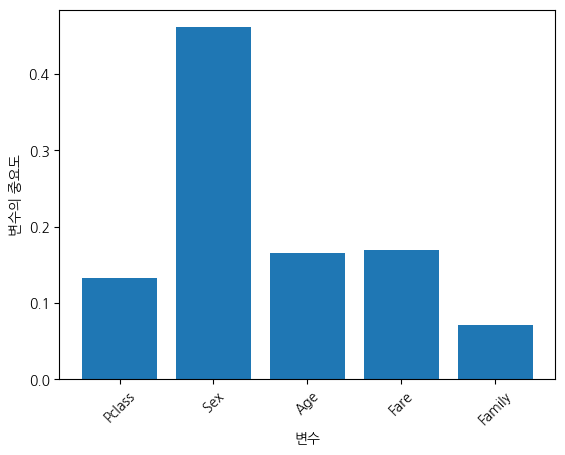

In [52]:
plt.bar(X.columns, best_gradient_boost.feature_importances_)
plt.xlabel('변수')
plt.ylabel('변수의 중요도')
plt.xticks(rotation=45)
plt.show()

예측하는데 family는 별로 중요하지 않다고 한다. 이를 제거하고 머신러닝을 해보자

In [53]:
model=GradientBoostingClassifier(random_state=1234)

In [54]:
hyperparam = {
    "loss": ["deviance", "exponential"],
    "n_estimators": np.arange(40, 210, 10),
    "learning_rate": np.arange(0.01, 0.21, 0.01),
    "max_depth": np.arange(3, 8, 1),
    "max_features": ["sqrt"]
}

In [55]:
gradient_grid=GridSearchCV(estimator=model, param_grid=hyperparam, cv=5, n_jobs=-1, verbose=1)

In [56]:
gradient_grid.fit(X_train.drop("Family", axis=1), Y_train)

Fitting 5 folds for each of 3400 candidates, totalling 17000 fits


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
8500 fits failed out of a total of 17000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3154 fits failed with the following error:
Traceback (most recent call last):
  File "c:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "c:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "c:\ProgramData\anaconda3\Lib\site-pa

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=1234),
             n_jobs=-1,
             param_grid={'learning_rate': array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 ]),
                         'loss': ['deviance', 'exponential'],
                         'max_depth': array([3, 4, 5, 6, 7]),
                         'max_features': ['sqrt'],
                         'n_estimators': array([ 40,  50,  60,  70,  80,  90, 100, 110, 120, 130, 140, 150, 160,
       170, 180, 190, 200])},
             verbose=1)

In [57]:
best_model=gradient_grid.best_estimator_

In [58]:
def temp(model):
    Y_train_pred = model.predict(X_train.drop("Family", axis=1))
    Y_test_pred = model.predict(X_test.drop("Family", axis=1))
    Y_train_prob = model.predict_proba(X_train.drop("Family", axis=1))[:, 1]
    Y_test_prob = model.predict_proba(X_test.drop("Family", axis=1))[:, 1]
    print('학습 능력')
    print('학습 정확도 : ', accuracy_score(Y_train, Y_train_pred))
    print('학습 f1 score : ', f1_score(Y_train, Y_train_pred))
    print('학습 AUC : ', roc_auc_score(Y_train, Y_train_prob))
    print('\n')
    print('일반화 능력')
    print('검정 정확도 : ', accuracy_score(Y_test, Y_test_pred))
    print('검정 f1 score : ', f1_score(Y_test, Y_test_pred))
    print('검정 AUC : ', roc_auc_score(Y_test, Y_test_prob))

In [59]:
temp(best_model)

학습 능력
학습 정확도 :  0.8441330998248686
학습 f1 score :  0.7855421686746988
학습 AUC :  0.9227125928186349


일반화 능력
검정 정확도 :  0.8041958041958042
검정 f1 score :  0.7407407407407407
검정 AUC :  0.8776876267748479


In [60]:
print(eval_classifier(best_gradient_boost))

학습 능력
학습 정확도 :  0.861646234676007
학습 f1 score :  0.8068459657701712
학습 AUC :  0.9434505645407385


일반화 능력
검정 정확도 :  0.8041958041958042
검정 f1 score :  0.7407407407407407
검정 AUC :  0.8852941176470588
None


변수를 제거한 것이 점수가 더 낮게 나왔다. 따라서 변수는 모든것을 다 사용한다
<br>**overfit의 위험은?**

## 최종 모델

In [81]:
best_gradient_boost.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.01,
 'loss': 'exponential',
 'max_depth': 5,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': 1234,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

loss, learning_rate, max_Depth, max_features, n_estimators, random_state 옵션 지정

In [61]:
#최종 모델
final_model=GradientBoostingClassifier(loss="exponential", learning_rate=0.01, max_depth=5, 
                                       max_features='sqrt', n_estimators=40, random_state=1234)

In [62]:
#모델 학습
final_model.fit(X_train, Y_train)

GradientBoostingClassifier(learning_rate=0.01, loss='exponential', max_depth=5,
                           max_features='sqrt', n_estimators=40,
                           random_state=1234)

In [63]:
result=pd.concat([X_test, Y_test], axis=1)
result

,Pclass,Sex,Age,Fare,Family,Survived
661,3,0,40.0,7.2250,0,0
599,1,0,49.0,56.9292,1,1
808,2,0,39.0,13.0000,0,0
332,1,0,38.0,153.4625,1,0
559,3,1,36.0,17.4000,1,1
...,...,...,...,...,...,...
283,3,0,19.0,8.0500,0,1
456,1,0,65.0,26.5500,0,0
268,1,1,58.0,153.4625,1,1
843,3,0,34.5,6.4375,0,0


In [64]:
result["predict_survived"]=final_model.predict(X_test)

In [65]:
result

,Pclass,Sex,Age,Fare,Family,Survived,predict_survived
661,3,0,40.0,7.2250,0,0,0
599,1,0,49.0,56.9292,1,1,0
808,2,0,39.0,13.0000,0,0,0
332,1,0,38.0,153.4625,1,0,0
559,3,1,36.0,17.4000,1,1,0
...,...,...,...,...,...,...,...
283,3,0,19.0,8.0500,0,1,0
456,1,0,65.0,26.5500,0,0,0
268,1,1,58.0,153.4625,1,1,1
843,3,0,34.5,6.4375,0,0,0


- 오차행렬로 정리하기

In [66]:
result_table=pd.DataFrame(confusion_matrix(result["Survived"], result["predict_survived"]),
                          index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])
result_table

,Predicted 0,Predicted 1
Actual 0,82,3
Actual 1,21,37


행별 합으로 나누어주기(특이도, 재현율 구하기)

In [67]:
round(result_table.div(result_table.sum(axis=1), axis=0)*100,2)

,Predicted 0,Predicted 1
Actual 0,96.47,3.53
Actual 1,36.21,63.79


사망한 경우 예측은 잘하였지만 (특이도 : 96.47%) <br>
생존한 경우 예측은 잘하지 못하였다 (재현율 : 63.79%)